<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/321_balance-prior-post.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(prior-influence-notebook)=
# L'influenza della distribuzione a priori

In questo capitolo si focalizza sull'importanza e sulle implicazioni che derivano dalla scelta dei priori sul processo di aggiornamento bayesiano. Per illustrare questi concetti, esamineremo alcuni esempi tratti dal libro "Bayes Rules!" di Johnson e collaboratori {cite:p}`Johnson2022bayesrules`. 

## Preparazione del Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
import pymc as pm
import pymc.sampling_jax
import requests
import arviz as az
from scipy.stats import norm, t

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "balance_prior_posterior"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

## La Distribuzione a Priori

La distribuzione a priori assume un ruolo centrale nell'approccio bayesiano, poiché riflette le nostre conoscenze pregresse o le ipotesi sui parametri del modello prima di osservare i dati. Questo concetto è di fondamentale importanza perché consente di integrare le informazioni pregresse con i dati osservati al fine di ottenere una stima più precisa dei parametri. Le distribuzioni a priori possono variare in base al grado di certezza attribuito ai valori dei parametri.

### Distribuzioni a Priori Non Informative

Le distribuzioni a priori non informative sono caratterizzate da una totale mancanza di conoscenza pregressa e assegnano la stessa credibilità a tutti i valori dei parametri. Un esempio comune di distribuzione a priori non informativa è la distribuzione uniforme, basata sul "Principio della Ragione Insufficiente" formulato da Laplace (1774/1951). Secondo questo principio, in assenza di evidenze rilevanti pregresse, tutte le possibili configurazioni dei parametri sono considerate equiprobabili.

### Distribuzioni a Priori Debolmente Informative

Le distribuzioni a priori debolmente informative consentendo di integrare una quantità limitata di informazioni pregresse nei modelli statistici. Queste distribuzioni sono progettate per riflettere le nostre assunzioni su quali possono essere i valori "ragionevoli" dei parametri del modello, tenendo conto delle incertezze presenti nell'analisi. L'uso di informazioni a priori debolmente informative può contribuire a migliorare la stabilità dell'analisi senza influenzare in modo significativo le conclusioni derivate da essa.

Le distribuzioni a priori debolmente informative hanno la caratteristica di non "spostare" in modo significativo la distribuzione a posteriori in una direzione specifica. In altre parole, sono centrate su valori "neutri" dei parametri. Ad esempio, quando si trattano parametri che possono assumere valori positivi o negativi, la distribuzione a priori debolmente informativa potrebbe essere centrata sullo zero. Nel caso di parametri che rappresentano proporzioni, essa potrebbe essere centrata su 0.5.

Tuttavia, ciò che rende queste distribuzioni debolmente informative è la specifica definizione di un intervallo "plausibile" di valori dei parametri. Questo intervallo indica quali valori dei parametri sono considerati plausibili e quali sono invece considerati implausibili. Ad esempio, una distribuzione a priori debolmente informativa potrebbe suggerire che valori estremamente grandi o estremamente bassi dei parametri sono poco plausibili, concentrandosi su un intervallo più stretto di valori considerati ragionevoli.

In sintesi, le distribuzioni a priori debolmente informative sono utilizzate per incorporare informazioni pregresse limitate nei modelli bayesiani, contribuendo a stabilizzare le stime dei parametri senza influenzare in modo significativo le conclusioni derivate dai dati. Queste distribuzioni definiscono un intervallo plausibile di valori dei parametri, aiutando a guidare l'analisi verso soluzioni più verosimili senza imporre vincoli eccessivi sui risultati.

### Distribuzioni a Priori Informativa

Le conoscenze pregresse, acquisite attraverso ricerche precedenti, pareri esperti o una combinazione di entrambi, possono essere meticolosamente integrate nel processo di analisi mediante l'incorporazione nelle distribuzioni a priori. Queste distribuzioni sono comunemente conosciute come distribuzioni a priori informative. Esse rappresentano un mezzo per codificare in modo sistematico informazioni concrete e rilevanti che possono avere un notevole impatto sull'analisi statistica, fornendo una solida base di conoscenza su cui fondare l'inferenza bayesiana. 

Le distribuzioni a priori informative possono derivare da una vasta gamma di fonti, comprese ricerche pregresse, pareri di esperti nel campo e altre fonti affidabili. Questo approccio offre un metodo strutturato per integrare in modo coerente le conoscenze pregresse nel processo di analisi statistica. L'incorporazione di queste informazioni aggiuntive contribuisce notevolmente a migliorare la robustezza e l'accuratezza delle conclusioni derivate dai dati, fornendo una solida base empirica su cui basare le stime dei parametri del modello e le decisioni basate sull'analisi bayesiana.

Nell'ambito della ricerca psicologica, l'utilizzo di distribuzioni a priori informative è attualmente poco diffuso, tuttavia emergono segnali che all'interno della comunità statistica sta crescendo l'interesse per questa pratica, considerandola come un avanzamento promettente nel campo della data science.

## Il caso beta-binomiale

La formula $ p(\theta \mid y) \propto p(\theta) \times p(y \mid \theta) $ è fondamentale per la comprensione dell'inferenza bayesiana. Essa illustra chiaramente che la distribuzione a posteriori emerge dalla congiunzione tra la distribuzione a priori e la funzione di verosimiglianza associata ai dati osservati. Questa sinergia permette di integrare informazioni a priori con evidenze empiriche recenti, risultando in una stima a posteriori del parametro $ \theta $ che è caratterizzata da un elevato grado di precisione e informatività.

Nel corso di questo capitolo, faremo uso di due funzioni specifiche per esplorare il modello beta-binomiale: `plot_beta_binomial` e `summarize_beta_binomial`. La prima funzione permette di visualizzare graficamente le distribuzioni a priori, di verosimiglianza e a posteriori, offrendo quindi un quadro intuitivo dell'aggiornamento bayesiano. La seconda funzione, invece, si concentra sull'estrazione di statistiche descrittive come la media, la moda e la varianza dalla distribuzione a posteriori. Entrambe queste risorse provengono dal testo di {cite:t}`Johnson2022bayesrules` e saranno strumentali per una comprensione approfondita del modello in esame.

In [3]:
def plot_beta_binomial(alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True) -> None:
    """Plot a Beta-Binomial Bayesian Model
    
    Parameters:
    - alpha, beta: positive shape parameters of the prior Beta distribution
    - y: observed number of successes
    - n: observed number of trials
    - prior: indicates whether the prior distribution should be plotted
    - likelihood: indicates whether the scaled likelihood should be plotted
    - posterior: indicates whether the posterior distribution should be plotted
    """
    
    θ = np.linspace(0, 1, 100)  # Range of possible values for θ
    
    if prior:
        p_theta = stats.beta.pdf(θ, alpha, beta)
        plt.fill_between(θ, p_theta, step='mid', alpha=0.2, color='blue', label='Prior')
    
    if y is not None and n is not None:
        if likelihood:
            likelihood_values = stats.binom.pmf(y, n, θ)
            scale_factor = integrate.simpson(y=likelihood_values, x=θ)  # Corrected to use keyword arguments
            plt.plot(θ, likelihood_values / scale_factor, color='orange', label='Likelihood (scaled)', lw=2)
        
        if posterior:
            alpha_post = alpha + y
            beta_post = beta + n - y
            p_theta_post = stats.beta.pdf(θ, alpha_post, beta_post)
            plt.fill_between(θ, p_theta_post, step='mid', alpha=0.4, color='green', label='Posterior')
    
    plt.xlabel(r'$\theta$')
    plt.ylabel('Density')
    plt.legend(loc='upper left')
    plt.title('Beta-Binomial Model')
    plt.show()


def summarize_beta_binomial(alpha, beta, y=None, n=None):
    """Summarize a Beta-Binomial Bayesian model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y number of successes
    @param n number of trials

    Return: Pandas dataframe summarizing beta binomial
    """

    def beta_mean(a, b):
        return a / (a + b)

    def beta_mode(a, b):
        if a < 1 and b < 1:
            return "0 and 1"
        elif a <= 1 and b > 1:
            return 0
        elif a > 1 and b < 1:
            return 1
        else:
            return (a - 1) / (a + b - 2)

    def beta_var(a, b):
        return a * b / ((a + b) ** 2 * (a + b + 1))

    prior_mean = beta_mean(alpha, beta)
    prior_mode = beta_mode(alpha, beta)
    prior_var = beta_var(alpha, beta)
    prior_sd = np.sqrt(prior_var)
    if y is None and n is None:
        summary = pd.DataFrame(
            {
                "alpha": alpha,
                "beta": beta,
                "mean": prior_mean,
                "mode": prior_mode,
                "var": prior_var,
                "sd": prior_sd,
            },
            index=["prior"],
        )
    else:
        post_alpha = y + alpha
        post_beta = n - y + beta
        post_mean = beta_mean(post_alpha, post_beta)
        post_mode = beta_mode(post_alpha, post_beta)
        post_var = beta_var(post_alpha, post_beta)
        post_sd = np.sqrt(post_var)
        summary = pd.DataFrame(
            {
                "alpha": [alpha, post_alpha],
                "beta": [beta, post_beta],
                "mean": [prior_mean, post_mean],
                "mode": [prior_mode, post_mode],
                "var": [prior_var, post_var],
                "sd": [prior_sd, post_sd],
            },
            index=["prior", "posterior"],
        )
    return summary

Nel caso in cui disponiamo di un campione di dati di dimensioni molto ridotte, come ad esempio 15 successi su 20 tentativi in una distribuzione beta-binomiale, la distribuzione a priori può esercitare un notevole impatto sulla distribuzione a posteriori. In contrasto, se consideriamo una distribuzione a priori uniforme, la distribuzione a posteriori assomiglierà alla funzione di verosimiglianza, con l'eccezione dell'area sotto le due curve. In parole più semplici, quando la distribuzione a priori è uniforme, la distribuzione a posteriori presenterà un picco nella stima di massima verosimiglianza. Tuttavia, quando adottiamo diverse distribuzioni a priori, la distribuzione a posteriori potrebbe notevolmente discostarsi.

Cominciamo esaminando il caso in cui viene adottata una distribuzione a priori uniforme.

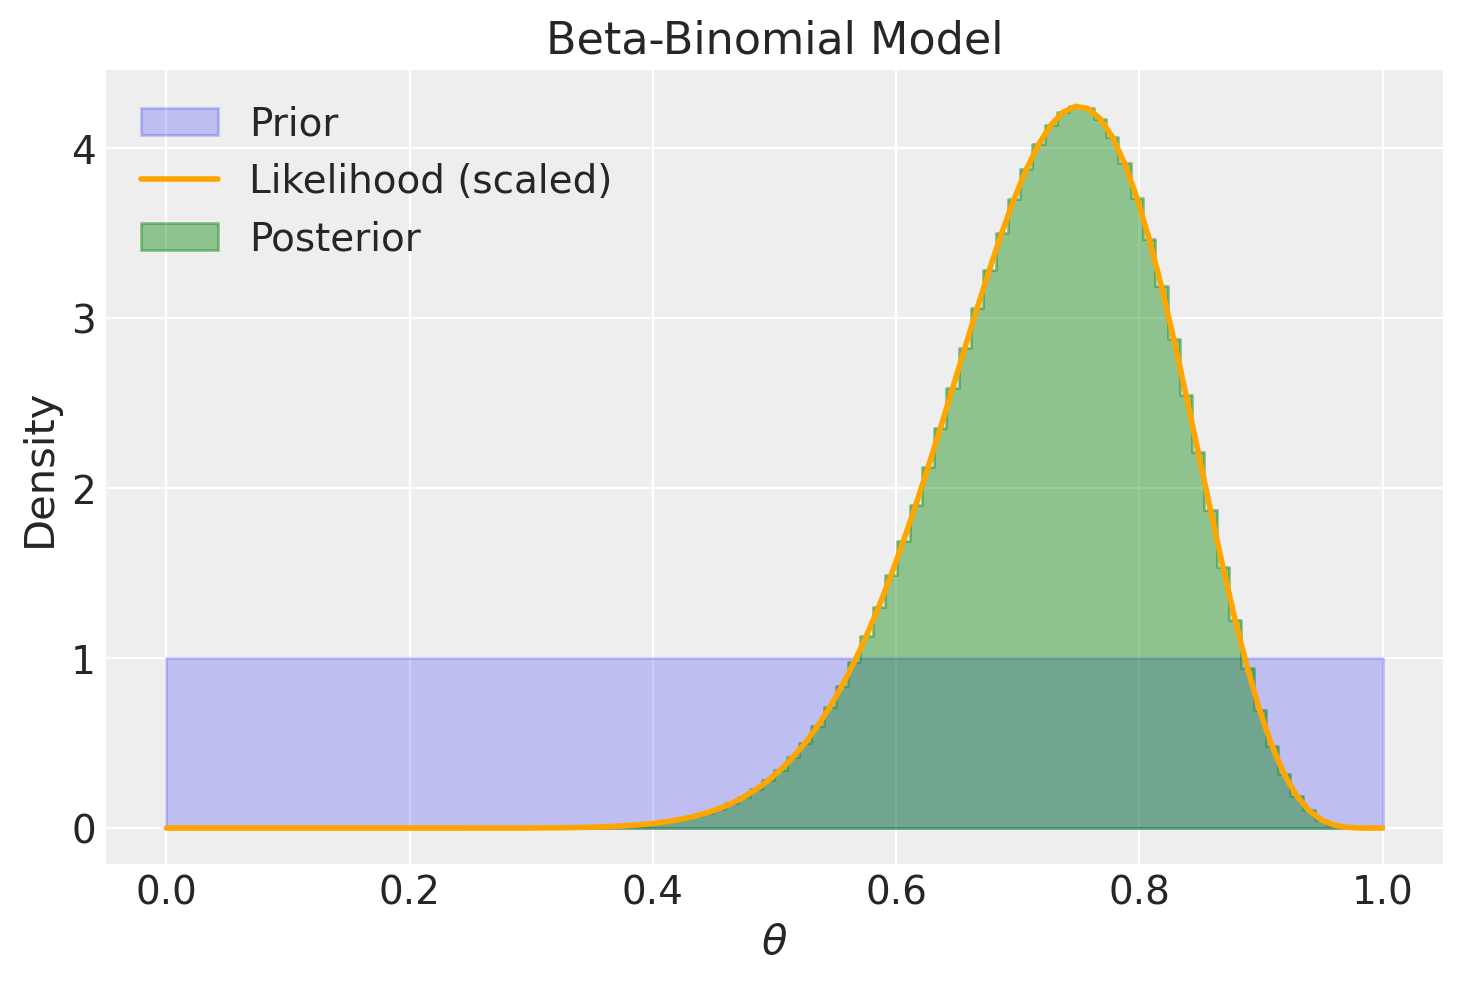

In [4]:
plot_beta_binomial(alpha=1, beta=1, y=15, n=20)

Esaminiamo ora l'effetto di una distribuzione a priori poco informativa, come ad esempio una Beta(2, 2). In questa situazione, l'impatto di tale scelta sulla distribuzione a posteriori è di modesta entità, ma comunque presente. Questo fenomeno può essere interpretato come un effetto di "regolarizzazione", il quale influisce sulla nostra stima in modo più cauto rispetto a quanto ottenuto tramite il principio di massima verosimiglianza. In altre parole, la stima risultante risulta essere più "bilanciata" verso il valore intermedio di 0.5.

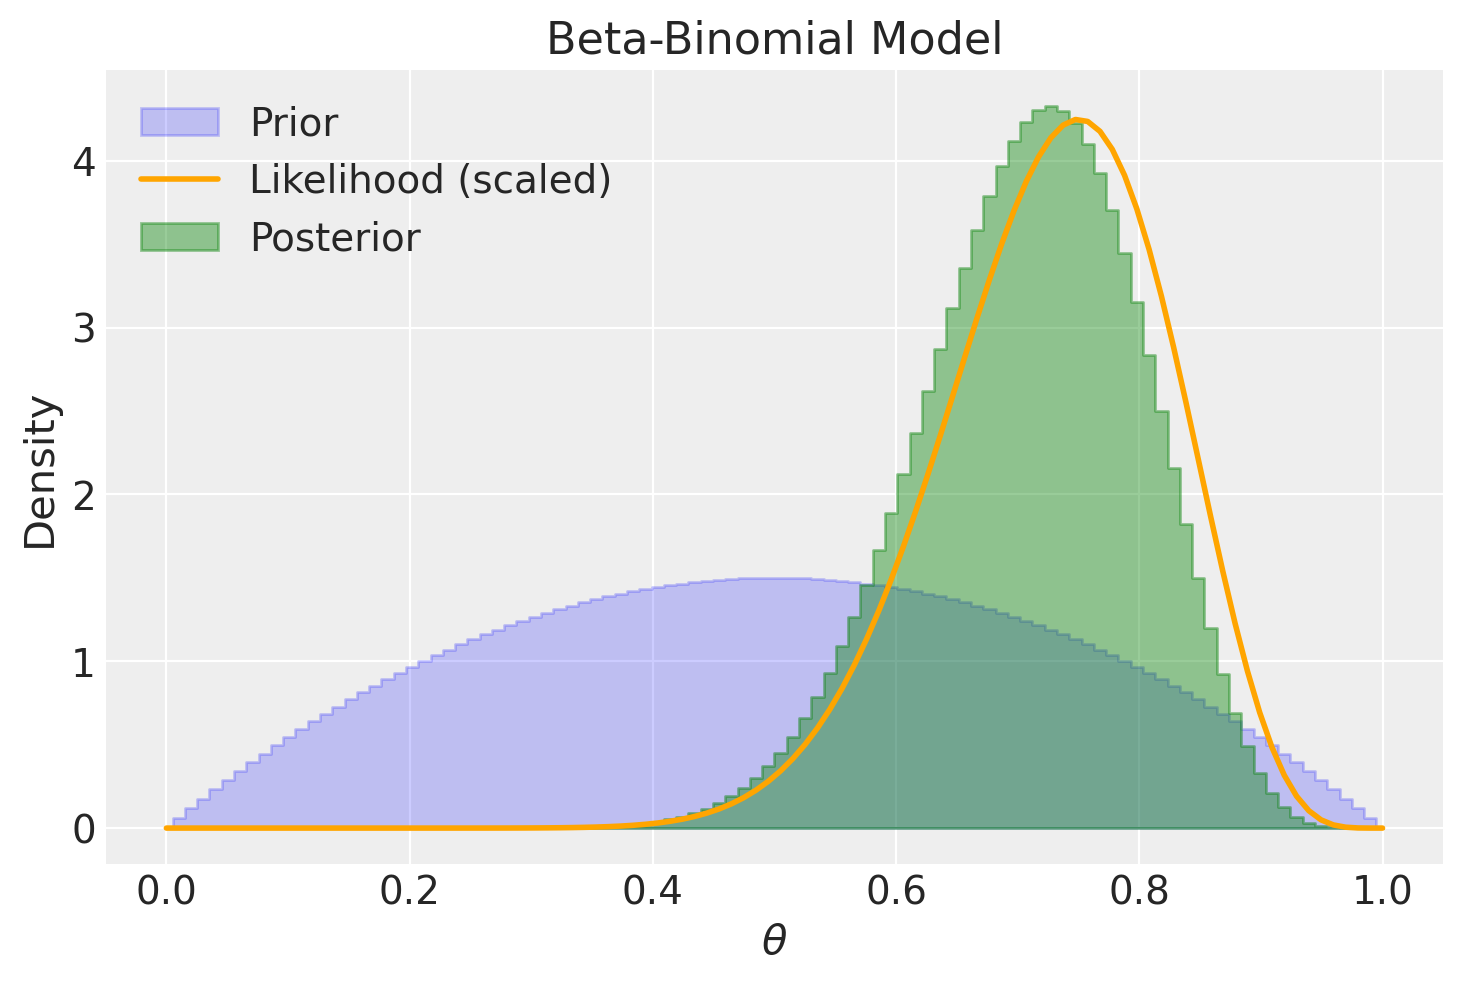

In [5]:
plot_beta_binomial(alpha=2, beta=2, y=15, n=20)

In [6]:
summarize_beta_binomial(alpha=2, beta=2, y=15, n=20)

alpha  beta      mean      mode       var        sd
prior          2     2  0.500000  0.500000  0.050000  0.223607
posterior     17     7  0.708333  0.727273  0.008264  0.090906

Se il campione è di dimensioni maggiori, l'adozione di una distribuzione a priori Beta(2, 2) ha un effetto trascurabile: infatti, il valore massimo della distribuzione a posteriori risulta essere quasi identico alla stima di massima verosimiglianza.

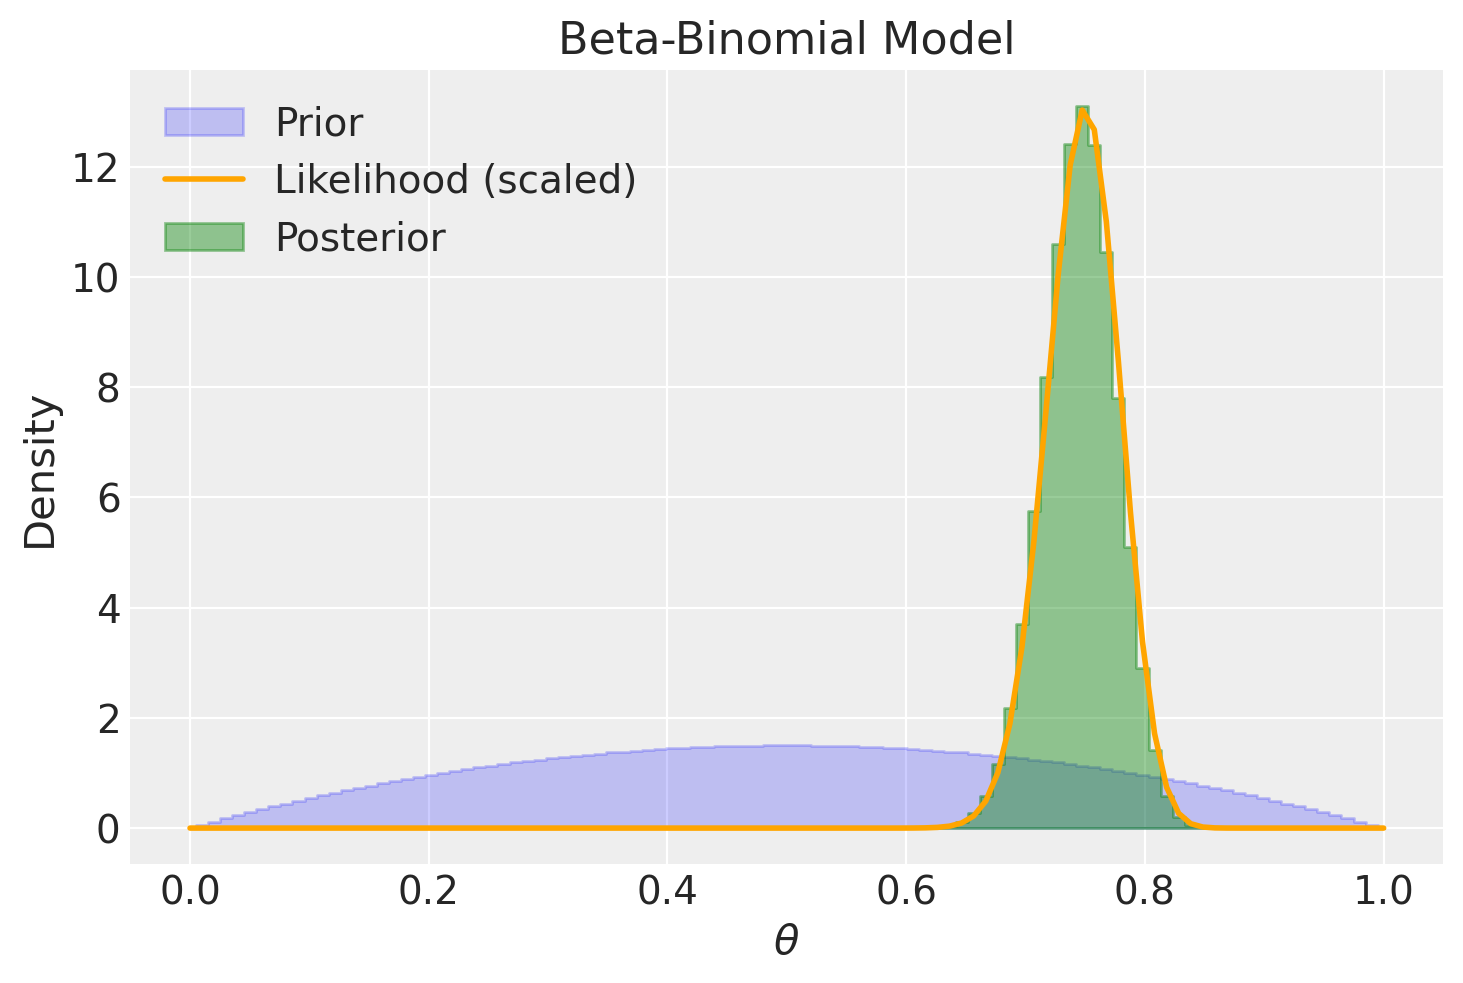

In [7]:
plot_beta_binomial(alpha=2, beta=2, y=150, n=200)

In [8]:
summarize_beta_binomial(alpha=2, beta=2, y=150, n=200)

alpha  beta      mean      mode       var        sd
prior          2     2  0.500000  0.500000  0.050000  0.223607
posterior    152    52  0.745098  0.747525  0.000926  0.030438

Se optiamo per una distribuzione a priori informativa, questa avrà un notevole impatto sulla distribuzione a posteriori quando ci si trova di fronte a un campione di dimensioni ridotte.

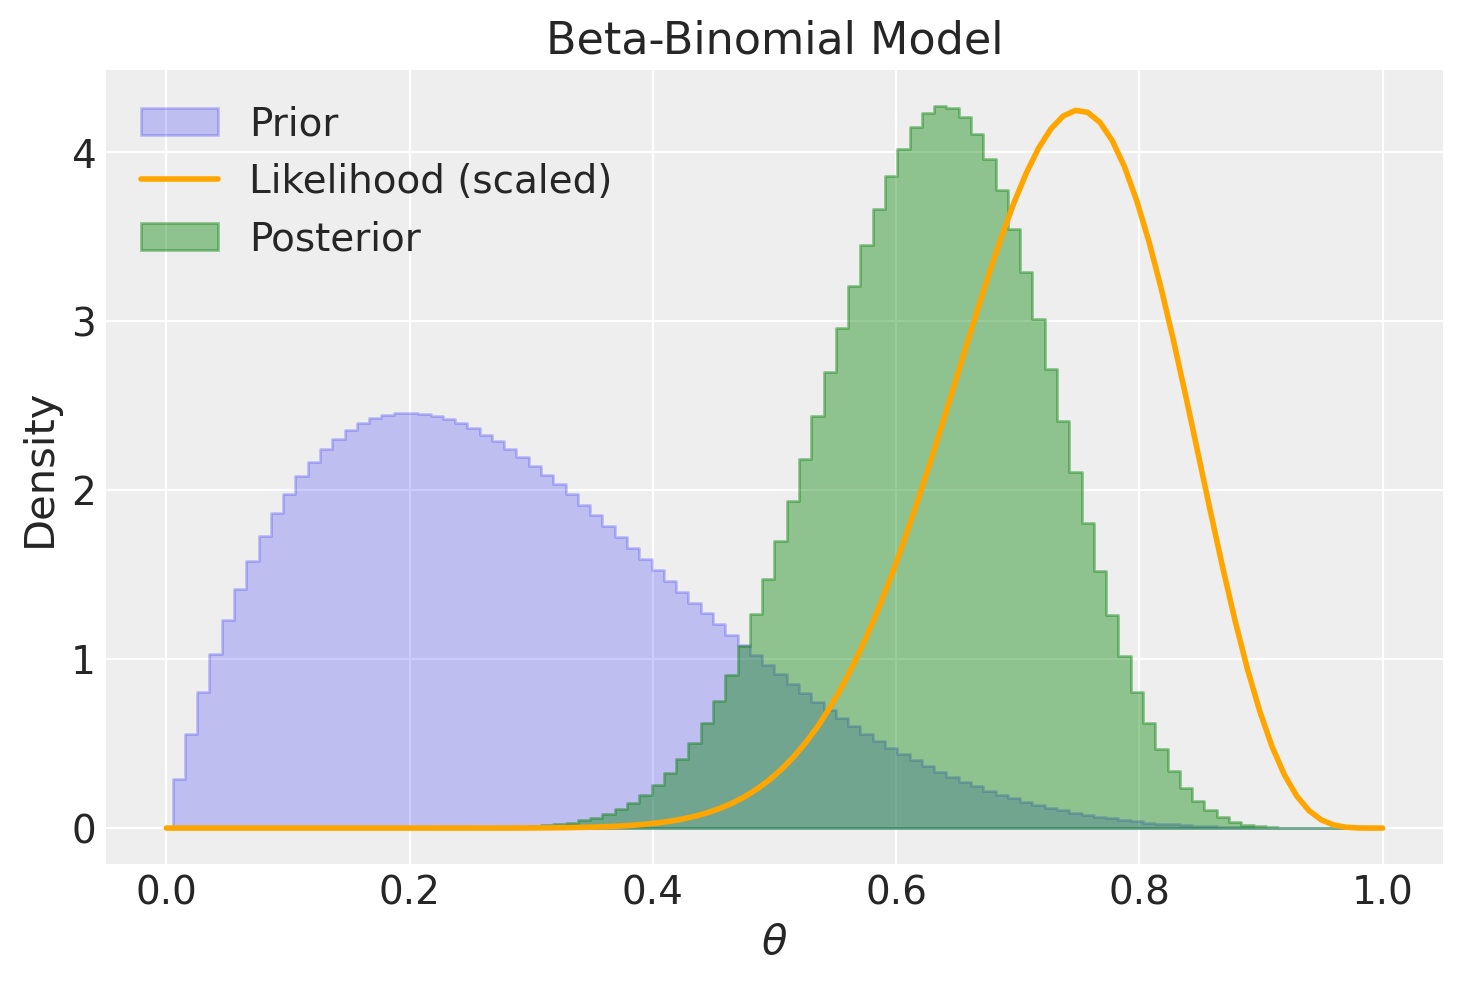

In [9]:
plot_beta_binomial(alpha=2, beta=5, y=15, n=20)

In [10]:
summarize_beta_binomial(alpha=2, beta=5, y=15, n=20)

alpha  beta      mean  mode       var        sd
prior          2     5  0.285714  0.20  0.025510  0.159719
posterior     17    10  0.629630  0.64  0.008328  0.091260

Al contrario, la medesima distribuzione a priori ha un effetto insignificante sulla distribuzione a posteriori quando il campione è di dimensioni considerevoli.

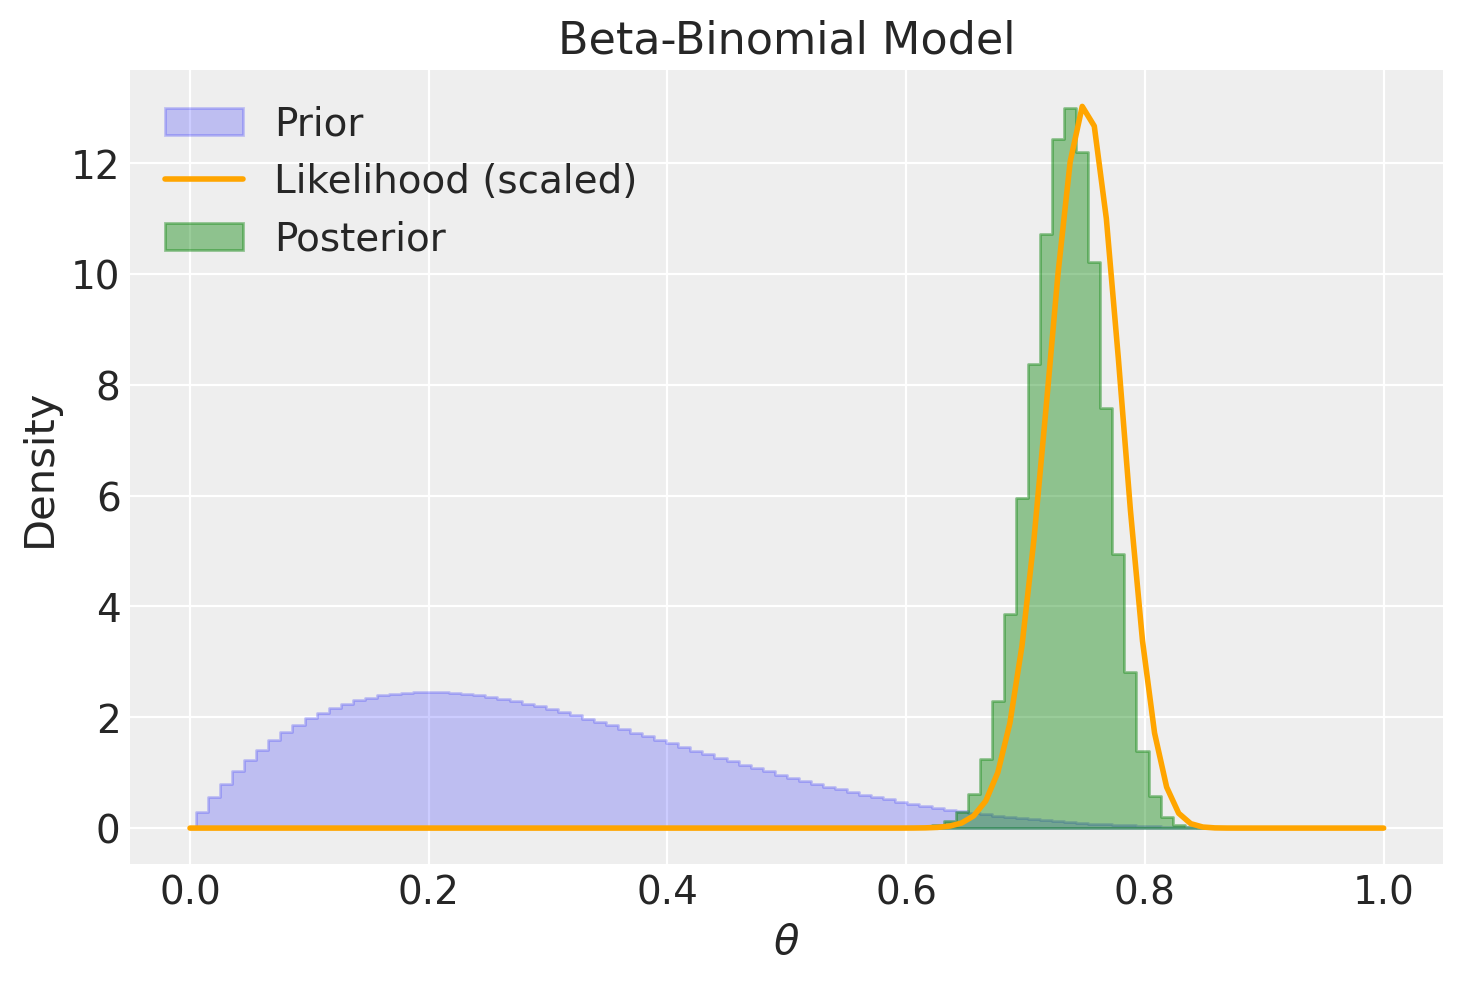

In [11]:
plot_beta_binomial(alpha=2, beta=5, y=150, n=200)

In [12]:
summarize_beta_binomial(alpha=2, beta=5, y=150, n=200)

alpha  beta      mean      mode       var        sd
prior          2     5  0.285714  0.200000  0.025510  0.159719
posterior    152    55  0.734300  0.736585  0.000938  0.030627

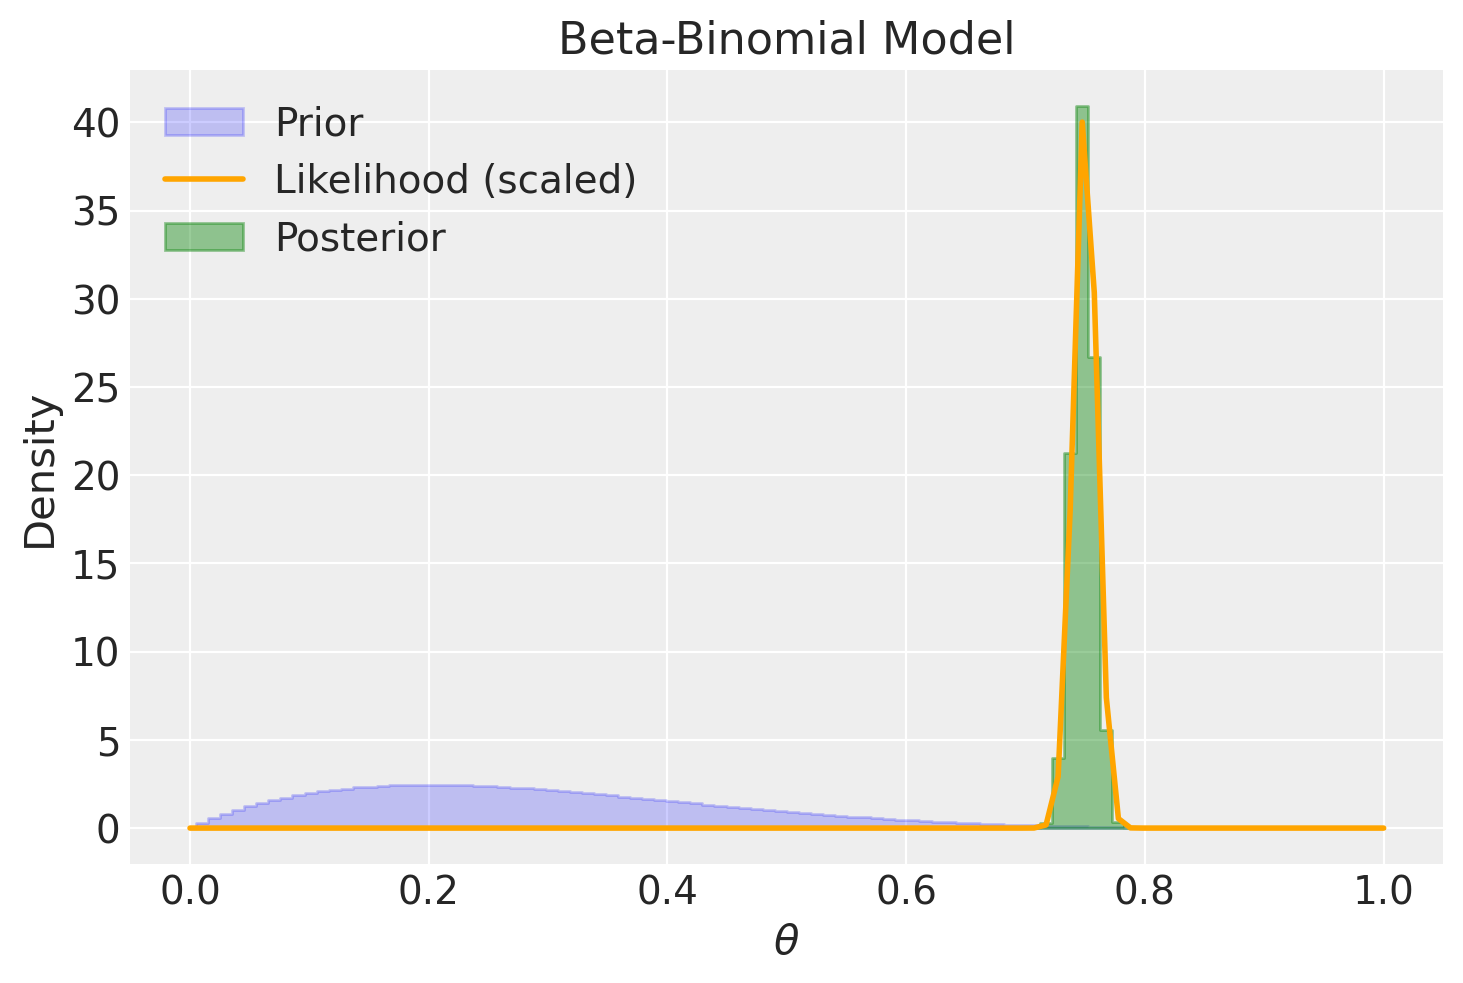

In [13]:
plot_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

In [14]:
summarize_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

alpha  beta      mean      mode       var        sd
prior          2     5  0.285714  0.200000  0.025510  0.159719
posterior   1502   505  0.748381  0.748628  0.000094  0.009684

## Connessione tra intuizioni e teoria

L'equilibrio tra la distribuzione a priori e le evidenze provenienti dai dati, come dimostrato negli esempi precedenti, non solo rispecchia le nostre intuizioni, ma rappresenta anche una necessità matematica. Questo concetto diventa chiaro esaminando la formula del valore atteso della distribuzione a posteriori nel contesto del caso beta-binomiale, che può essere riscritta come segue:

$$
\begin{align}
\mathbb{E}_{\text{post}} &[\text{Beta}(\alpha + y, \beta + n - y)] = \frac{\alpha + y}{\alpha + \beta + n} \\
&= \frac{a+b}{a+b+n} \cdot \frac{a}{a+b} + \frac{n}{a+b+n} \cdot \frac{y}{n}.
\end{align}
$$ 

L'equazione precedente rivela che il valore atteso a posteriori si ottiene come una media ponderata tra il valore atteso a priori $\left( \frac{\alpha}{\alpha+\beta}\right)$ e la proporzione osservata dei successi $\left(\frac{y}{n}\right)$. I pesi sono dati da $\left( \frac{\alpha+\beta}{\alpha+\beta+n}\right)$ e $\left( \frac{n}{\alpha+\beta+n}\right)$. Pertanto, quando il numero di osservazioni $n$ è significativo rispetto alla somma dei parametri $\alpha + \beta$, la distribuzione a posteriori sarà principalmente influenzata dai dati osservati e in minor misura dalle credenze a priori. Al contrario, se $n$ è piccolo rispetto a $\alpha + \beta$, i dati avranno un peso inferiore rispetto alle credenze a priori.

Queste considerazioni indicano come scegliere i parametri $\alpha$ e $\beta$: se desideriamo rappresentare una totale ignoranza sul fenomeno, una scelta coerente è $\alpha = \beta = 1$ (attribuiamo uguale credibilità a ogni valore di $\theta$). Se, invece, possediamo forti credenze a priori, possiamo selezionare $\alpha$ in modo da eguagliare il valore atteso a priori, mentre $\alpha + \beta$ rifletterà l'importanza attribuita all'informazione a priori: maggiore è il valore di $\alpha + \beta$, maggiore sarà il numero di dati necessari per influenzare significativamente la distribuzione a posteriori rispetto a quella a priori. In situazioni in cui $n$ è considerevolmente grande, la distribuzione a posteriori avrà un impatto ridotto sulla distribuzione a priori, a meno che non si facciano scelte estreme per i parametri a priori.

## Un Esempio Controintuitivo

Esaminiamo ora un altro esempio proposto in un tweet di McElreath:

> Lesson: Don't trust intuition, for even simple prior+likelihood scenarios defy it. Four examples below, each producing radically different posteriors. Can you guess what each does?

```{image} ../images/mcelreath_post_1.png
:height: 400px
:align: center
```

Nella figura successiva vediamo la risposta alla domanda precedente.

```{image} ../images/mcelreath_post_2.png
:height: 400px
:align: center
```

McElreath descrive le caratteristiche di quattro diversi scenari in cui si combinano distribuzioni normali (Gaussiane) e Student-t (con 2 gradi di libertà) per il prior e la likelihood. La distribuzione gaussiana ha code molto sottili, mentre quella di Student-t ha code più spesse.

1. **In Alto a Sinistra: Prior Normale, Likelihood Normale**
   - `y ~ Normal(mu,1)`
   - `mu ~ Normal(10,1)`
   In questo scenario classico di aggiornamento bayesiano, il posterior risulta essere un compromesso tra il prior e la likelihood. La distribuzione normale, con le sue code sottili, contribuisce a un aggiornamento più "prevedibile" e concentrato attorno al valore medio.

2. **In Alto a Destra: Prior Student, Likelihood Student (df=2)**
   - `y ~ Student(2,mu,1)`
   - `mu ~ Student(2,10,1)`
   In questo caso, entrambe le distribuzioni hanno code più spesse. La presenza di "extra massa" nelle code significa che ciascuna distribuzione trova il modo dell'altra più plausibile, portando a una media che non rappresenta il miglior "compromesso". Questo scenario risulta in una maggiore incertezza e un posterior meno definito.

3. **In Basso a Sinistra: Prior Student, Likelihood Normale**
   - `y ~ Normal(mu,1)`
   - `mu ~ Student(2,10,1)`
   Qui, la likelihood normale, con le sue code sottili, tende a dominare. Essa è molto scettica nei confronti del prior con code spesse, ma il prior di Student-t non è sorpreso dalla likelihood. Questo porta a un posterior che è più influenzato dalla likelihood normale.

4. **In Basso a Destra: Prior Normale, Likelihood Student**
   - `y ~ Student(2,mu,1)`
   - `mu ~ Normal(10,1)`
   In questo ultimo scenario, è il prior normale a dominare. Il ragionamento è simile a quello del caso precedente, ma in senso inverso. Il prior normale, con le sue code sottili, impone una maggiore influenza sul posterior, rendendolo meno influenzato dalle code più spesse della likelihood di Student-t.

In sintesi, la combinazione di queste due distribuzioni in diversi modi porta a risultati di aggiornamento bayesiano molto differenti, a seconda di quale tra prior e likelihood abbia le code più spesse e quindi eserciti una maggiore influenza sul posterior.

Di seguito è riportato il codice per riprodurre i risultati delle figure precedenti.

In [15]:
# Observed data
yobs = 0

# Number of samples
n_samples = 2000

# Model with normal prior and normal likelihood
with pm.Model() as mnn:
    mu = pm.Normal('mu', mu=10, sigma=1)
    y = pm.Normal('y', mu=mu, sigma=1, observed=yobs)
    trace_mnn = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

# Model with t prior and t likelihood
with pm.Model() as mtt:
    mu = pm.StudentT('mu', nu=2, mu=10, sigma=1)
    y = pm.StudentT('y', nu=2, mu=mu, sigma=1, observed=yobs)
    trace_mtt = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

# Model with t prior and normal likelihood
with pm.Model() as mnt:
    mu = pm.StudentT('mu', nu=2, mu=10, sigma=1)
    y = pm.Normal('y', mu=mu, sigma=1, observed=yobs)
    trace_mnt = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

# Model with normal prior and t likelihood
with pm.Model() as mtn:
    mu = pm.Normal('mu', mu=10, sigma=1)
    y = pm.StudentT('y', nu=2, mu=mu, sigma=1, observed=yobs)
    trace_mtn = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

Compiling...


Compilation time = 0:00:01.545217
Sampling...
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/3000 [00:02<?, ?it/s]

Running chain 3: 100%|██████████| 3000/3000 [00:02<00:00, 1312.27it/s]
Sampling time = 0:00:02.652808
Transforming variables...
Transformation time = 0:00:00.099841
Compiling...
Compilation time = 0:00:00.571719
Sampling...
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 3000/3000 [00:01<00:00, 1591.21it/s]
Sampling time = 0:00:01.982962
Transforming variables...
Transformation time = 0:00:00.053744
Compiling...
Compilation time = 0:00:00.421561
Sampling...
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 3000/3000 [00:01<00:00, 1734.54it/s]
Sampling time = 0:00:01.823367
Transforming variables...
Transformation time = 0:00:00.049707
Compiling...
Compilation time = 0:00:00

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_61930/765634110.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


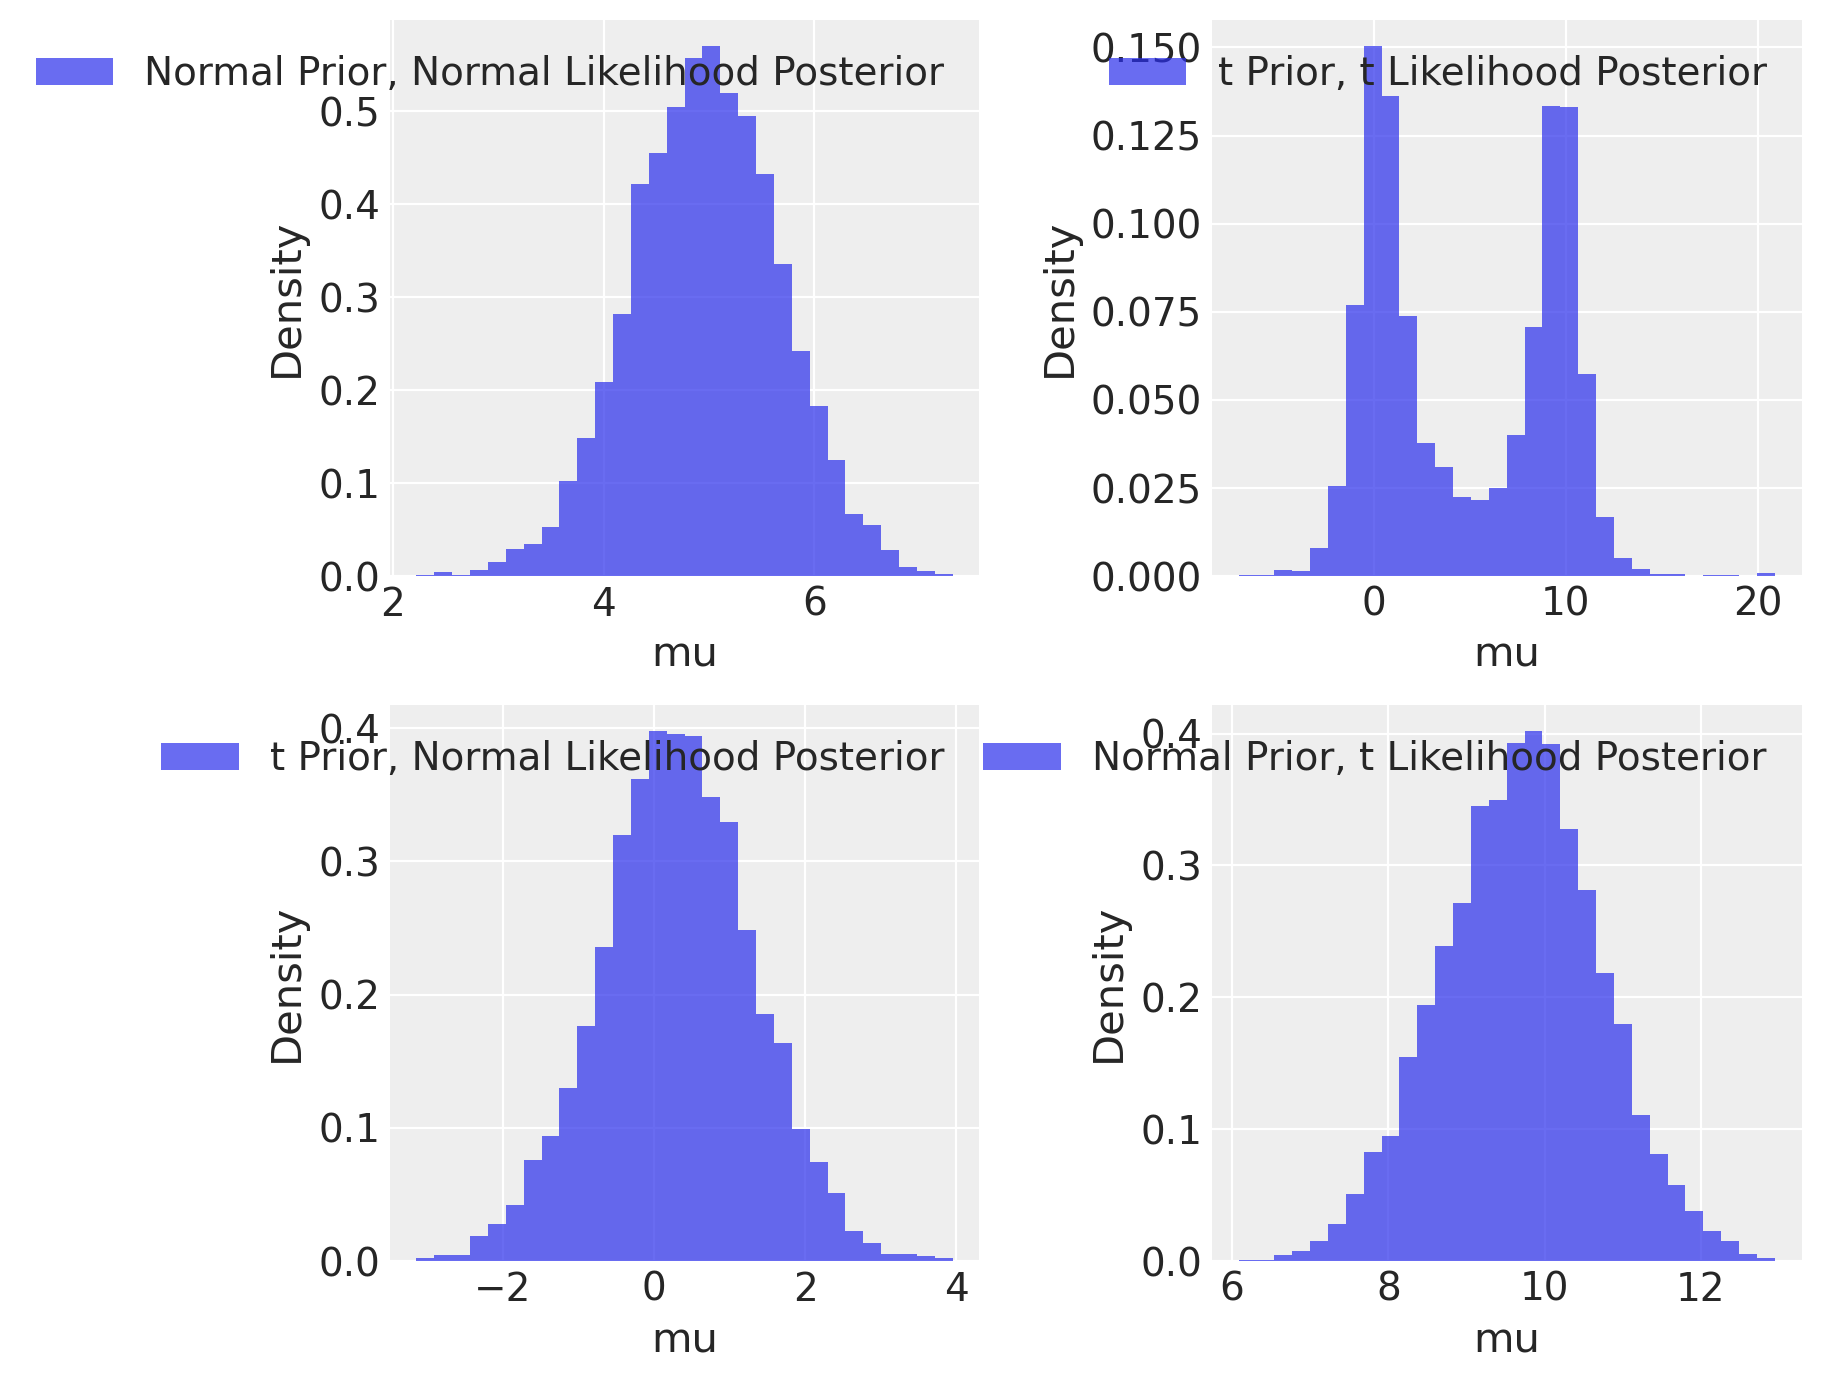

In [16]:
# Function to plot the results
def plot_posterior(trace, model_name):
    mu_samples = trace.posterior['mu'].values.flatten()  # Extracting 'mu' samples
    plt.hist(mu_samples, density=True, bins=30, alpha=0.7, label=f'{model_name} Posterior')
    plt.xlabel('mu')
    plt.ylabel('Density')
    plt.legend()

# Plotting the results
plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1)
plot_posterior(trace_mnn, 'Normal Prior, Normal Likelihood')

plt.subplot(2, 2, 2)
plot_posterior(trace_mtt, 't Prior, t Likelihood')

plt.subplot(2, 2, 3)
plot_posterior(trace_mnt, 't Prior, Normal Likelihood')

plt.subplot(2, 2, 4)
plot_posterior(trace_mtn, 'Normal Prior, t Likelihood')
plt.tight_layout()
plt.show()

In conclusione, ad eccezione del caso gaussiano, i risultati non sono affatto intuitivi. Pertanto, in contesti come questi, affidarsi esclusivamente alle proprie intuizioni non è una scelta consigliabile. È invece fondamentale procedere con l'esecuzione dei calcoli.

## Commenti e considerazioni finali 

La conclusione dell'esempio presentato da [Johnson (2022)](https://link.springer.com/chapter/10.1007/978-3-030-85974-1_6) ci offre una panoramica intuitiva ma fondamentale: l'aggiornamento bayesiano rispecchia i processi di ragionamento che intuitivamente utilizziamo nel quotidiano. Quando ci troviamo di fronte a nuove evidenze deboli, le nostre credenze preesistenti rimangono invariate. Al contrario, evidenze robuste ci costringono a rivedere e aggiornare le nostre credenze in linea con i nuovi dati. Questa è la quintessenza dell'approccio bayesiano: un meccanismo quantitativo e preciso che formalizza le nostre intuizioni.

Questo è in netto contrasto con l'approccio frequentista, che ignora le credenze o le conoscenze preesistenti. In questo schema, i risultati di un test statistico basato su un campione limitato di dati possono portare a una modifica delle credenze senza alcuna considerazione per le evidenze o le intuizioni pregresse. Questo divario metodologico tra i due approcci è sintetizzata con efficacia nella celebre striscia comica di [xkcd](https://xkcd.com/1132/).

Entrando nel dettaglio del contesto bayesiano, la scelta delle distribuzioni a priori è un elemento cruciale, con due obiettivi principali. In primo luogo, l'utilizzo di distribuzioni a priori debolmente informative agisce come un meccanismo di regolarizzazione, contribuendo a ottenere inferenze più prudenti mitigando l'effetto di osservazioni estreme. Questo aspetto è generalmente accettato e ritenuto non controverso nel campo statistico.

In secondo luogo, un settore in rapida crescita e di grande interesse è l'integrazione esplicita di conoscenza esperta preesistente. Tale processo, noto come 'elicitazione della conoscenza esperta' (*expert knowledge elicitation*) {cite:p}`brownstein2019role`, va ben oltre la semplice intervista con gli esperti. Esso richiede un elevato grado di rigore metodologico per prevenire l'insorgenza di bias cognitivi. Questo aspetto è particolarmente rilevante in ambiti come la psicologia, dove gli sviluppi teorici possono essere meno frequenti. Tale necessità è supportata da un'ampia letteratura accademica e da protocolli ben definiti, quali Cooke, SHELF e Delphi probabilistico {cite:p}`o2019expert`.

In conclusione, pur aspirando all'obiettività come ideale della ricerca scientifica, è indispensabile riconoscere e affrontare la soggettività intrinseca nel processo di scelta dei priori. Attraverso l'uso di protocolli rigorosi di elicitazione della conoscenza esperta, è possibile realizzare analisi bayesiane robuste e ben informate, che riflettano in modo accurato sia le incertezze intrinseche che la competenza specifica nel campo di studio.

## Informazioni sull'Ambiente di Sviluppo

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p jax

Last updated: Tue Apr 09 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.1

jax: 0.4.25

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

arviz     : 0.17.0
requests  : 2.31.0
numpy     : 1.26.4
seaborn   : 0.13.2
scipy     : 1.12.0
pandas    : 2.2.1
pymc      : 5.10.4
matplotlib: 3.8.3

Watermark: 2.4.3

